In [1]:
library(ggplot2)
library(data.table)
library(tidyr)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Cell type proportion plots

# Blood

In [4]:
res = fread('/data2/xiaojiashun/eQTL/data/cibersortx/CIBERSORTx_Job43_Results.csv', sep=',')
lm22_cells = fread('/data2/xiaojiashun/eQTL/data/cibersortx/LM22_celltypes.csv')
lm22_cells

Cell type,Category
<chr>,<chr>
B cells naive,B
B cells memory,B
Plasma cells,B
T cells CD8,CD8
T cells CD4 naive,CD4
T cells CD4 memory resting,CD4
T cells CD4 memory activated,CD4
T cells follicular helper,CD4
T cells regulatory (Tregs),CD4


In [5]:
cibersortx_res <- t(res[,2:23])
colnames(cibersortx_res) = res$Mixture
cibersortx_res = apply(cibersortx_res, 2, function(x) x/sum(x))
cibersortx_res <- cibersortx_res %>%
    merge(lm22_cells[,c('Cell type', 'Category')], by.x='row.names', by.y='Cell type', sort=T) %>%
    dplyr::rename(`Cell type`=Row.names) %>%
    relocate(Category, .after='Cell type')
cibersortx_props <- cibersortx_res %>% 
    group_by(Category) %>% 
    summarise(across(starts_with('GTE'), sum))
cibersortx_props_long <- cibersortx_props %>%
    tidyr::pivot_longer(cols=2:ncol(cibersortx_props), names_to='Sample', values_to='Prop') %>%
    mutate(Category=factor(Category, levels=c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC', 'Tgd', 'Mast', 'Eosinophil', 'Neutrophil')))
long <- cibersortx_props_long %>%
    dplyr::filter(Category %in% c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC', 'Neutrophil')) %>%
    mutate(Category=factor(Category, levels=c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC', 'Neutrophil')))

Warning message in structure(in_domain, pos = match(in_domain, breaks)):
“Calling 'structure(NULL, *)' is deprecated, as NULL cannot have attributes.
  Consider 'structure(list(), *)' instead.”


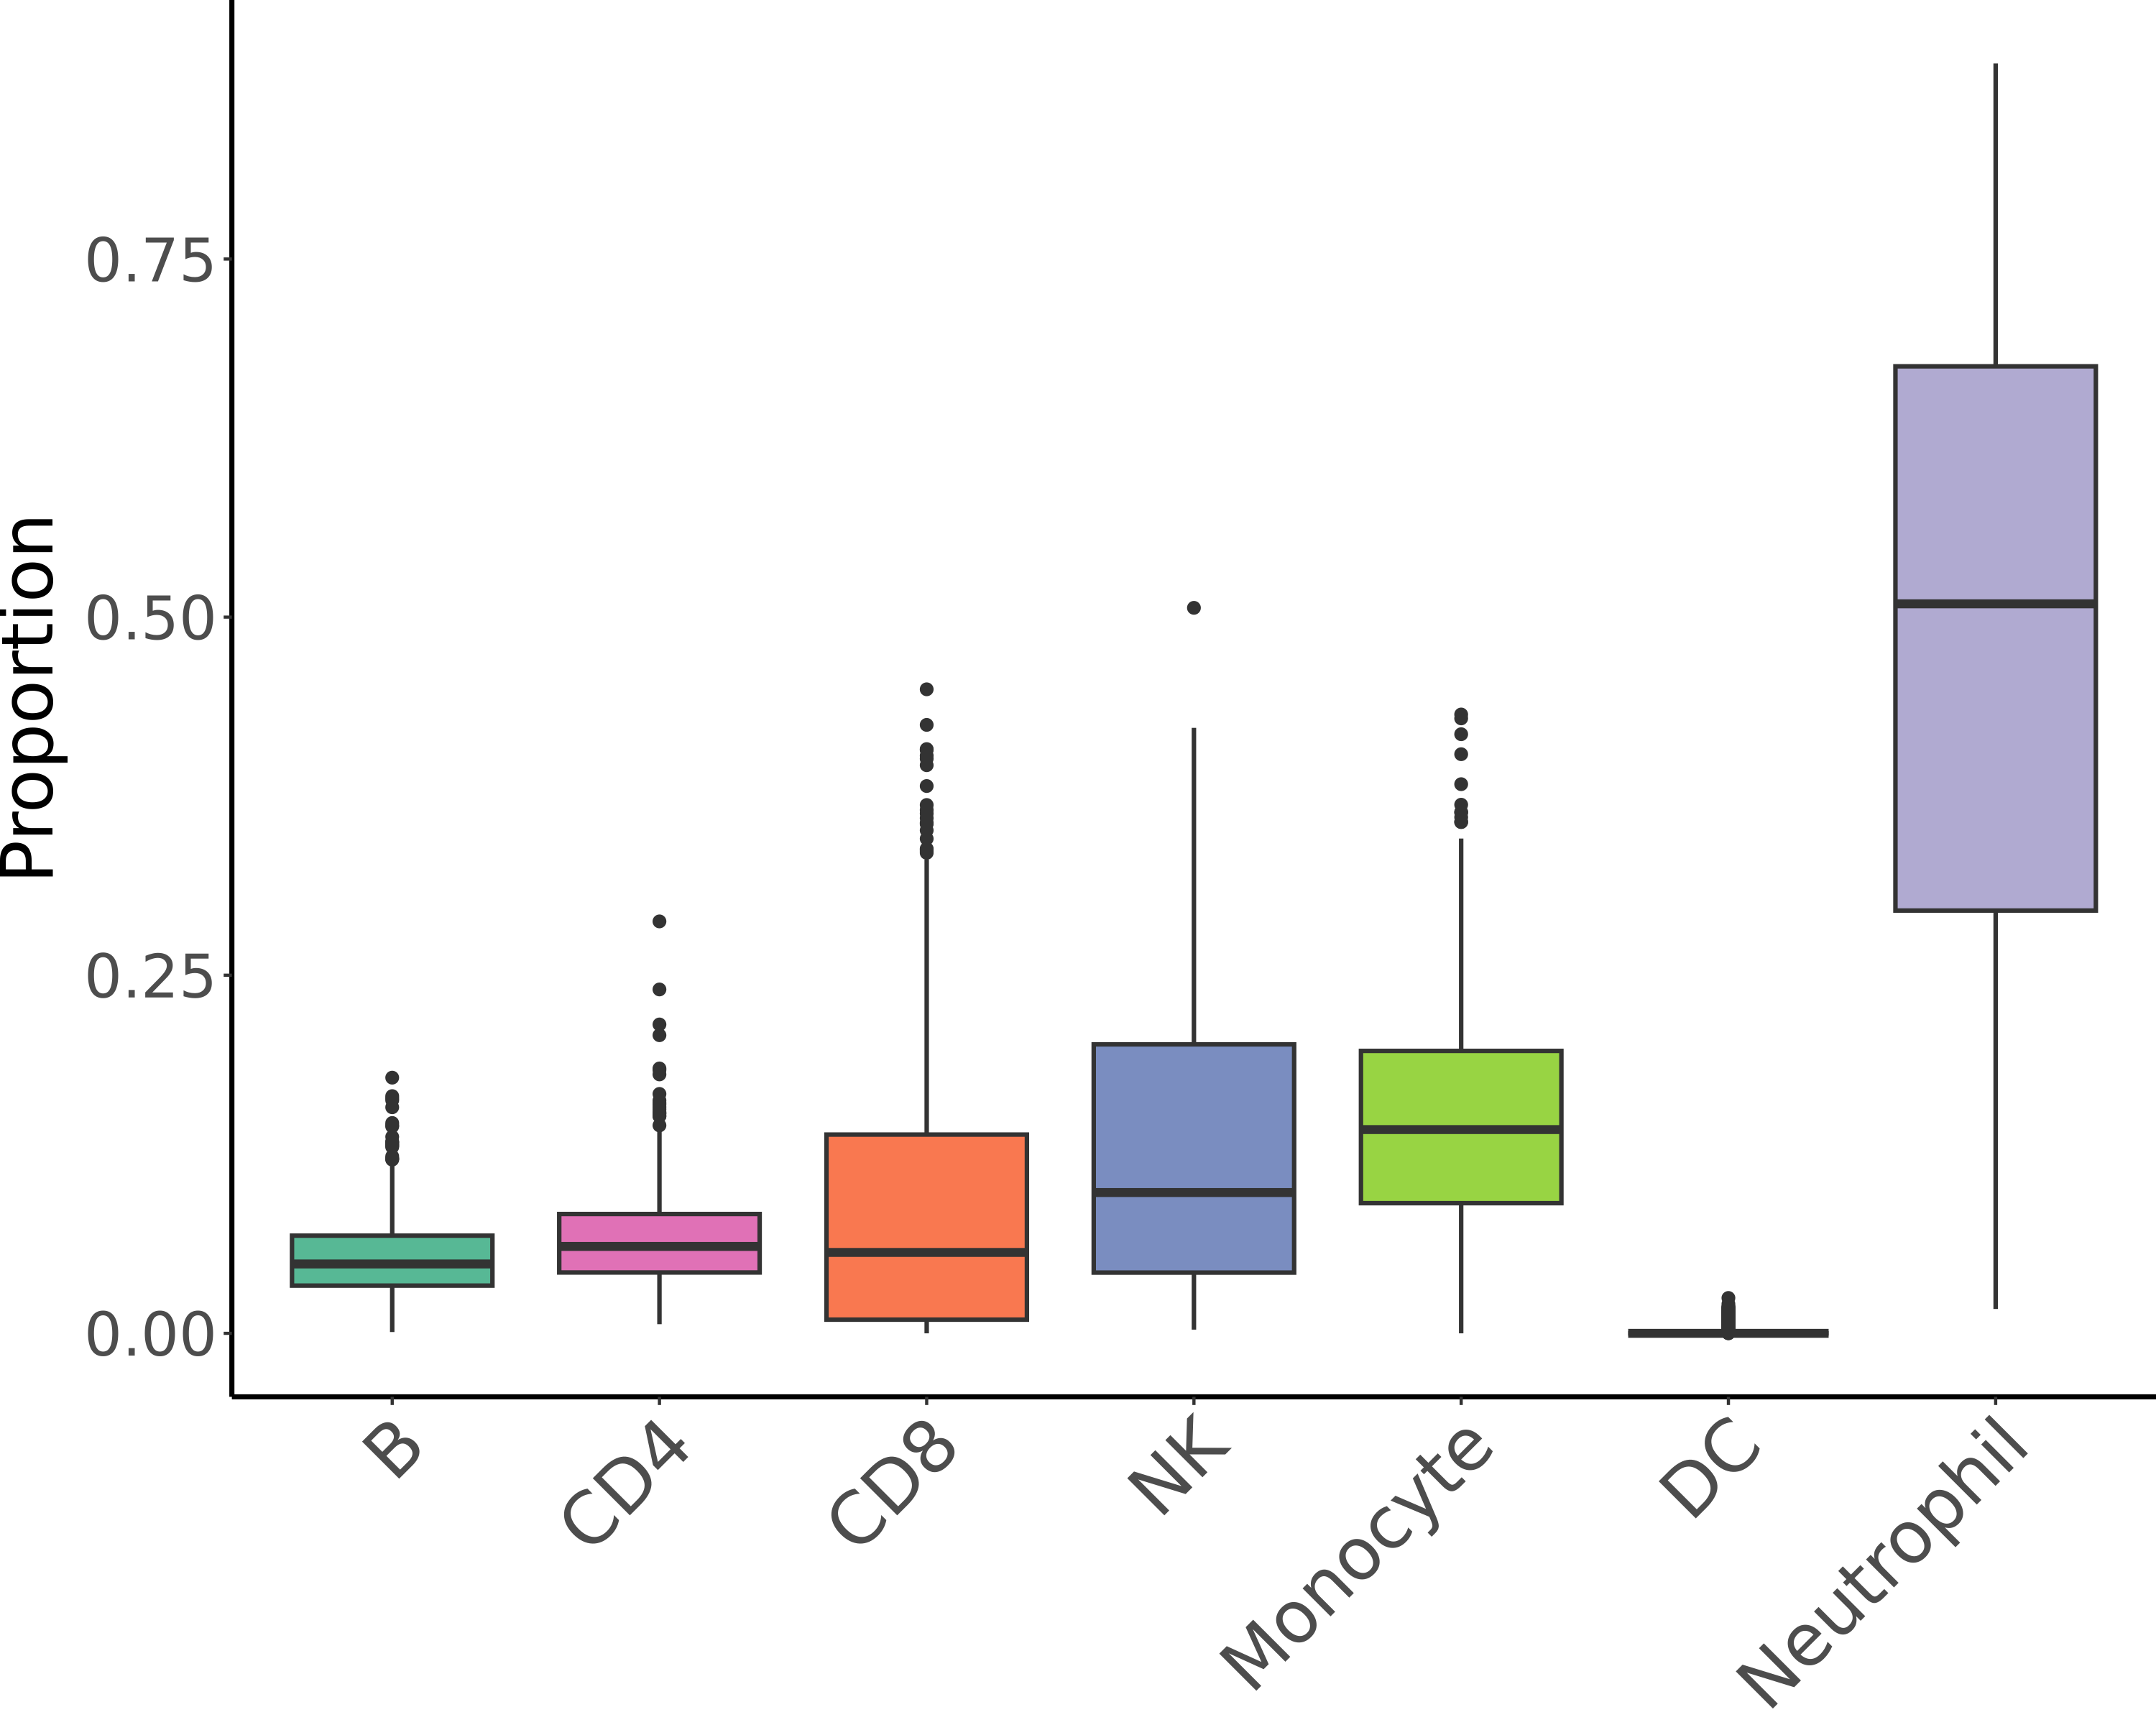

In [6]:
## boxplot
options(repr.plot.width=10, repr.plot.height=8, repr.plot.res=300)
colors = c('#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1')
label_font = 24
axis_font = 20
box = ggplot(long, aes(x=Category, y=Prop, fill=Category)) + 
  geom_boxplot(lwd=0.7, outlier.size=1.5) + 
  ylab('Proportion') + theme_classic() + 
  theme(axis.text.y=element_text(size=axis_font),
        axis.title.x=element_blank(),
        axis.title.y=element_text(size=label_font, margin = margin(t = 0, r = 5, b = 0, l = 0)),
        axis.text.x = element_text(size=label_font, angle = 45, hjust = 1),
        legend.position = "none",
        panel.background = element_blank(),
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.line.x=element_line(linewidth=0.8),
        axis.line.y=element_line(linewidth=0.8)) +
  scale_fill_manual(values=colors, breaks=levels, name=NULL)
box

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


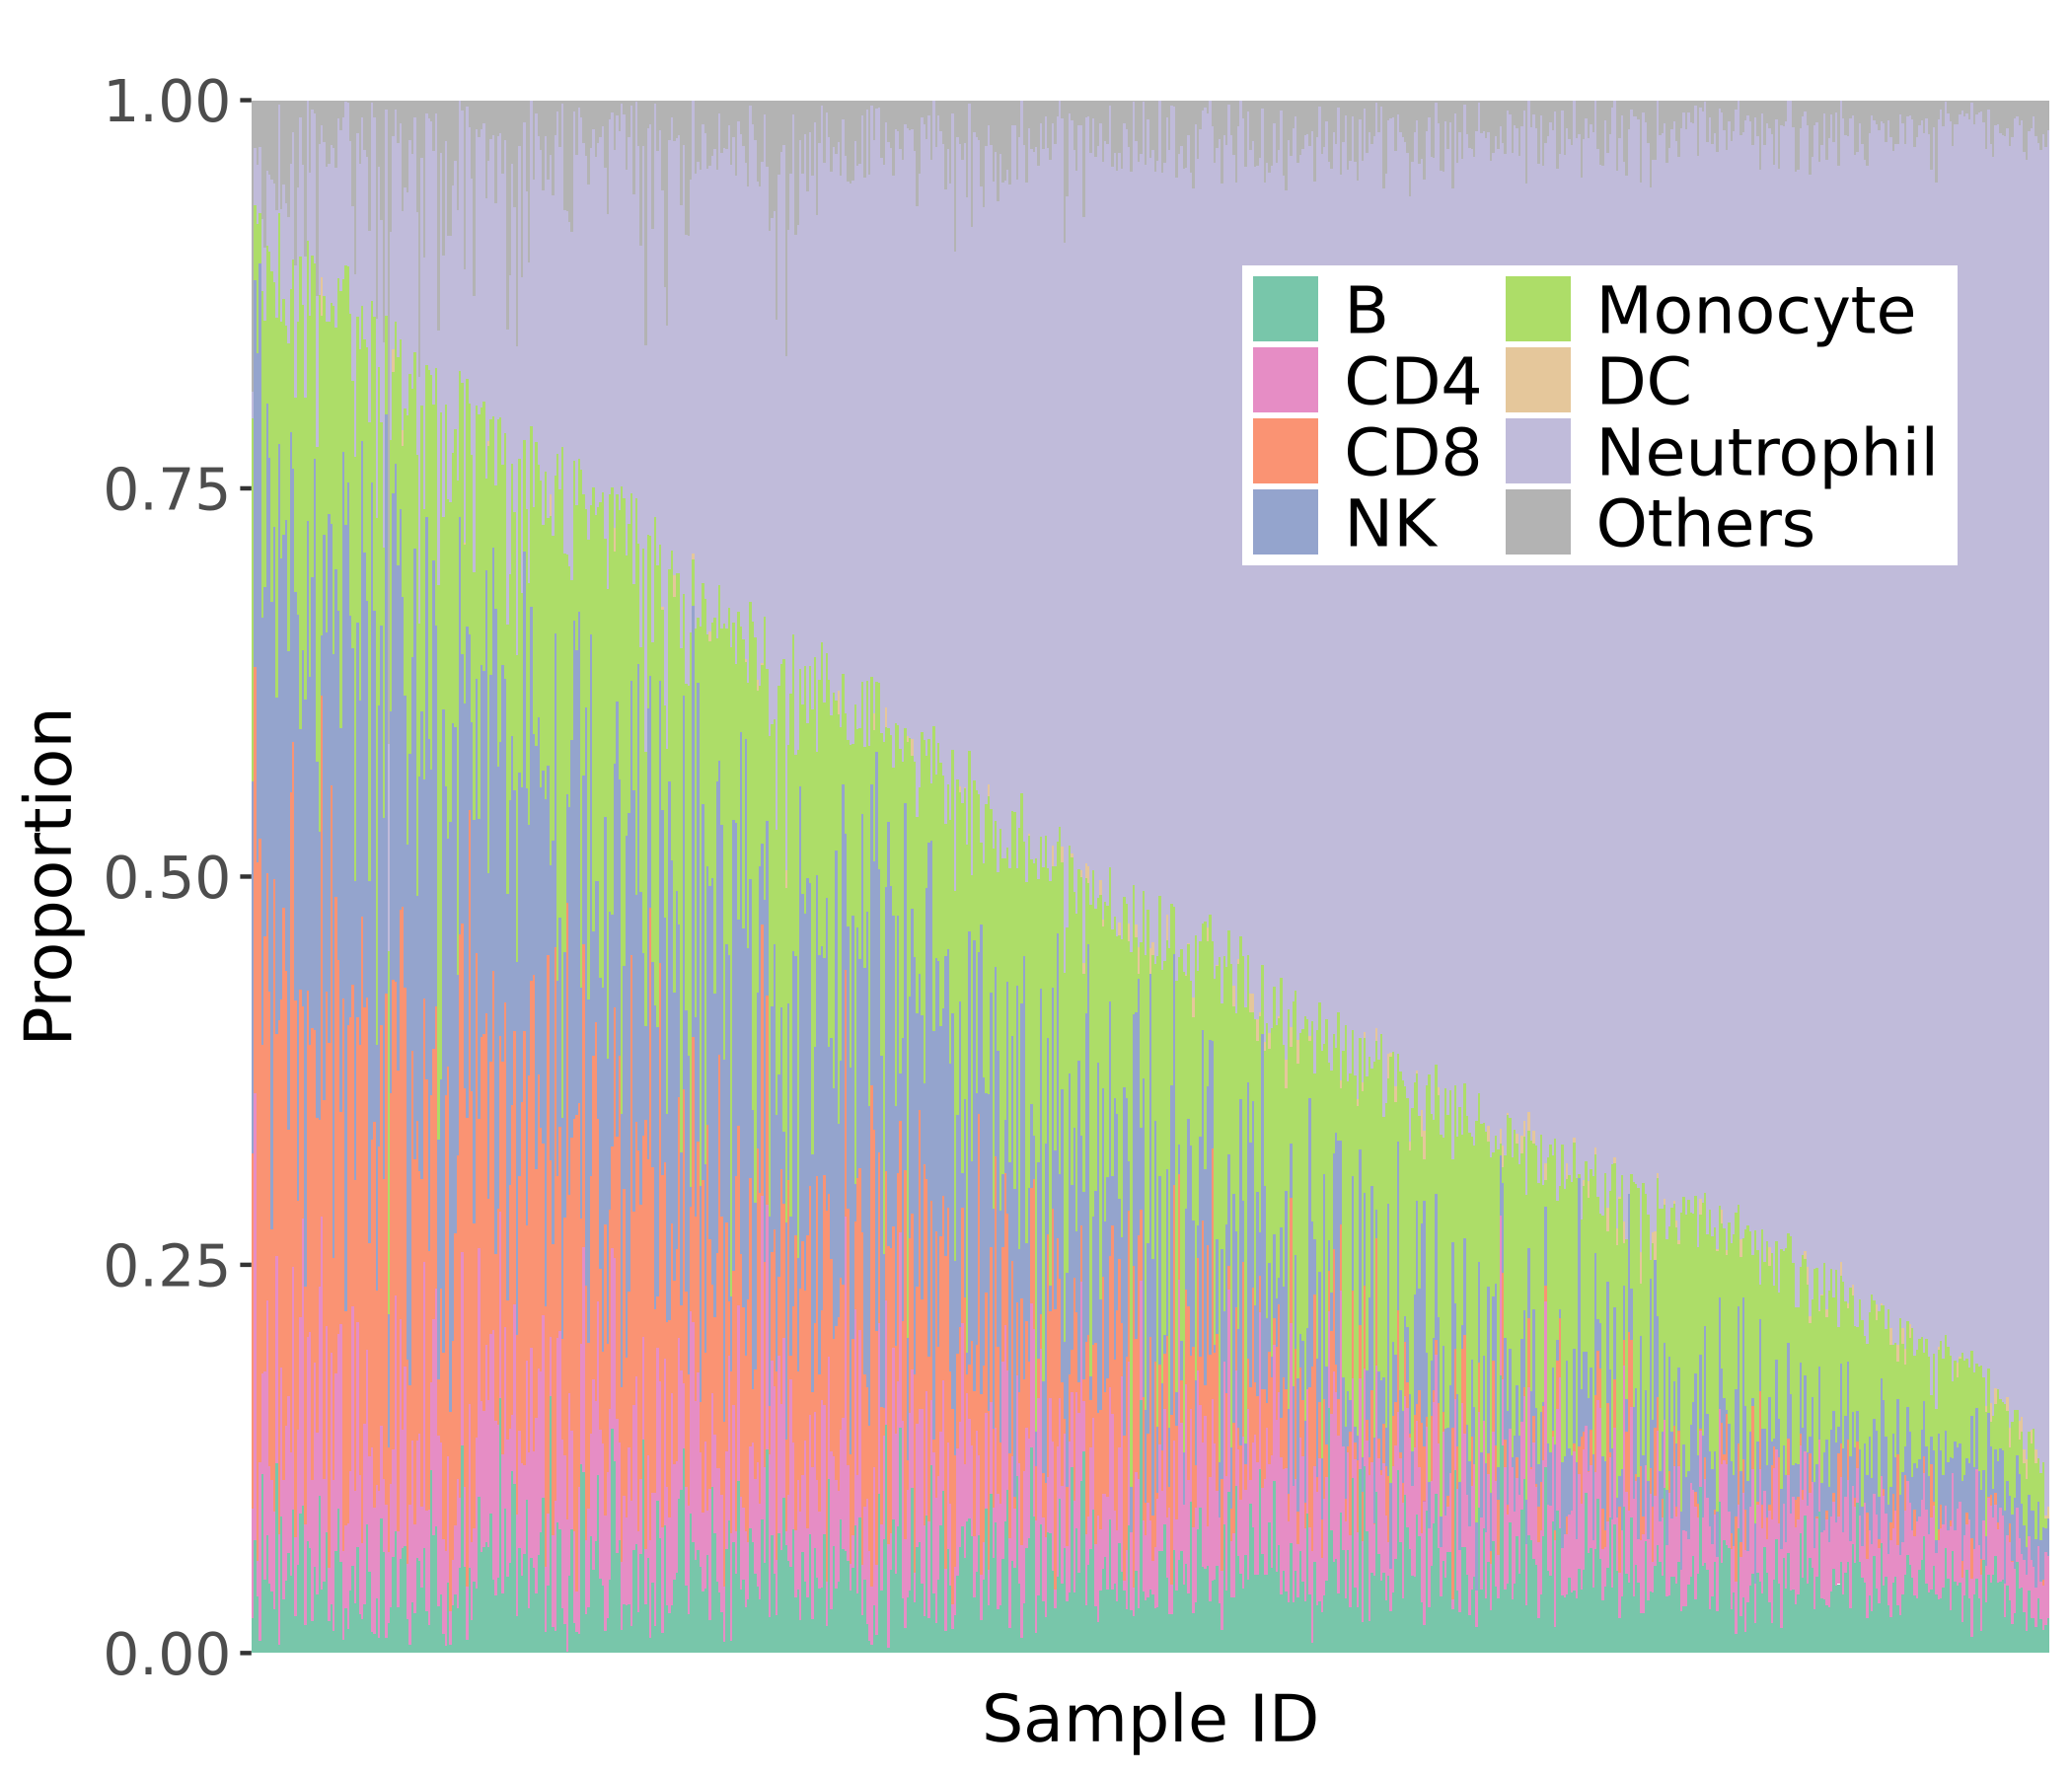

In [7]:
## barplot
props <- cibersortx_res[,-1]
props[props$Category %in% c('Tgd', 'Mast', 'Eosinophil'), 'Category'] = 'Others'
props <- props %>%
    group_by(Category) %>%
    summarize_all(sum) %>%
        as.data.frame()
wide = props[,-1] %>% t() %>% as.data.frame() %>% setNames(props[,1]) %>%  tibble::rownames_to_column("Sample")
cmns = colMeans(wide[,-1])
wide = wide[,c(1,8,6,7,4,3,2,5,9)]
levels = c('B', 'CD4', 'CD8', 'NK', 'Monocyte', 'DC', 'Neutrophil', 'Others')
wide2 = wide[order(wide$`Neutrophil`, decreasing=F),]
long2 <- wide2 %>% pivot_longer(cols=!Sample, names_to='Cell', values_to='Prop')
colors <- c('#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1', '#A0A0A0')
options(repr.plot.width=7, repr.plot.height=6, repr.plot.res=300)
bar = ggplot(long2, aes(fill=factor(Cell, levels=rev(levels)), y=Prop, x=factor(Sample, levels=wide2$Sample))) +
  geom_bar(position="fill", stat="identity", width=1, alpha=0.8) +
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.text.y=element_text(size=14),
        axis.title.x=element_text(size=16, margin = margin(t = -12, r = 0, b = 0, l = 0)),
        axis.title.y=element_text(size=16, margin = margin(t = 0, r = 5, b = 0, l = 0)),
        legend.text=element_text(size=16),
        legend.margin=margin(2,6,2,2),
        # legend.box.margin=margin(2,2,2,2),
        legend.box.spacing = unit(4, "pt"),
        legend.position = c(.75, .77),
        # legend.spacing.x = unit(2.0, 'cm'),
        panel.background = element_blank()) +
  guides(fill = guide_legend(nrow = 4)) +
  scale_fill_manual(values=colors, breaks=levels, name=NULL) +
  labs(x='Sample ID', y='Proportion') + ylim(c(0,1))
bar

# Brain

In [14]:
props_cibersortx = fread('/data2/xiaojiashun/eQTL/data/cibersortx/CIBERSORTx_Job28_Adjusted.txt', sep='\t')
props = t(props_cibersortx[,2:9])
colnames(props) = props_cibersortx$Mixture
props = data.frame(Category=colnames(props_cibersortx)[2:9], props)

In [15]:
props

,Category,GTEX.1117F.3226.SM.5N9CT,GTEX.111FC.3126.SM.5GZZ2,GTEX.1128S.2726.SM.5H12C,GTEX.117XS.3026.SM.5N9CA,GTEX.1192X.3126.SM.5N9BY,GTEX.11DXW.1126.SM.5H12Q,GTEX.11DXY.3226.SM.5GIDE,GTEX.11EI6.3026.SM.5GZZO,GTEX.11EMC.3226.SM.5EGKW,⋯,GTEX.ZAK1.3026.SM.5S2MJ,GTEX.ZDXO.2126.SM.4WKFI,GTEX.ZE7O.3126.SM.5HL5X,GTEX.ZE9C.3026.SM.4WKHB,GTEX.ZF28.3026.SM.4WKHP,GTEX.ZUA1.3026.SM.59HJC,GTEX.ZVT3.3026.SM.5E43N,GTEX.ZYFD.3026.SM.5E44C,GTEX.ZYY3.3126.SM.5SI9L,GTEX.ZZPT.3026.SM.5GZXH
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Inhibitory neurons,Inhibitory neurons,0.02874556,0.086255135,0.11372544,0.15034892,0.01646038,0.120331428,0.13236876,0.12749508,0.12374569,⋯,0.16078705,0.096963029,0.17928127,0.10544214,0.08782123,0.216806037,0.07206795,0.13455042,0.06380951,0.02321592
Oligodendrocytes,Oligodendrocytes,0.27457305,0.427105980,0.11313109,0.14352685,0.38351305,0.152124314,0.15185737,0.08253834,0.09732963,⋯,0.09625787,0.199566531,0.07048442,0.20961813,0.11872646,0.061739175,0.06800889,0.14070546,0.07188890,0.16867749
Excitatory neurons,Excitatory neurons,0.30349035,0.261924094,0.34643512,0.46696791,0.28043705,0.407552503,0.39074634,0.19691076,0.21272136,⋯,0.37045633,0.300199263,0.22103276,0.31752021,0.36414194,0.403595831,0.39726045,0.43142673,0.26837109,0.24047185
Astrocytes,Astrocytes,0.31274935,0.154278815,0.32824433,0.13134285,0.22785555,0.271054234,0.21250077,0.42833132,0.42088569,⋯,0.24932682,0.323896188,0.42094025,0.27711166,0.31579791,0.213238722,0.33953864,0.20460384,0.26782772,0.36239260
OPCs,OPCs,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,⋯,0.01893841,0.000000000,0.02897887,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000
Microglia,Microglia,0.00788571,0.042046170,0.03681524,0.03822771,0.02199521,0.023449412,0.06252987,0.08952167,0.03677396,⋯,0.04408067,0.033211624,0.02026029,0.03148678,0.03260198,0.058944182,0.03838289,0.02845113,0.08149202,0.07308910
Pericytes,Pericytes,0.01907288,0.004328325,0.02276023,0.01221892,0.01417747,0.006271039,0.01318450,0.02883886,0.03589709,⋯,0.01483023,0.005481026,0.02930820,0.02984526,0.03538505,0.009326207,0.01988303,0.02651155,0.11439328,0.07123116
Endothelial,Endothelial,0.05348311,0.024061480,0.03888854,0.05736684,0.05556129,0.019217070,0.03681238,0.04636397,0.07264657,⋯,0.04532262,0.040682339,0.02971394,0.02897581,0.04552543,0.036349844,0.06485814,0.03375087,0.13221747,0.06092188


In [16]:
## barplot
wide = props[,-1] %>% t() %>% as.data.frame() %>% setNames(props[,1]) %>%  tibble::rownames_to_column("Sample")
cmns = colMeans(wide[,-1])
ord = c(1, order(-cmns) + 1)
wide = wide[,ord]
levels = c('Excitatory neurons', 'Inhibitory neurons', 'Astrocytes', 'Oligodendrocytes',
           'Microglia', 'OPCs', 'Endothelial', 'Pericytes')
wide2 = wide[order(wide$`Excitatory neurons`, decreasing=T),]
long2 <- wide2 %>% pivot_longer(cols=!Sample, names_to='Cell', values_to='Prop')

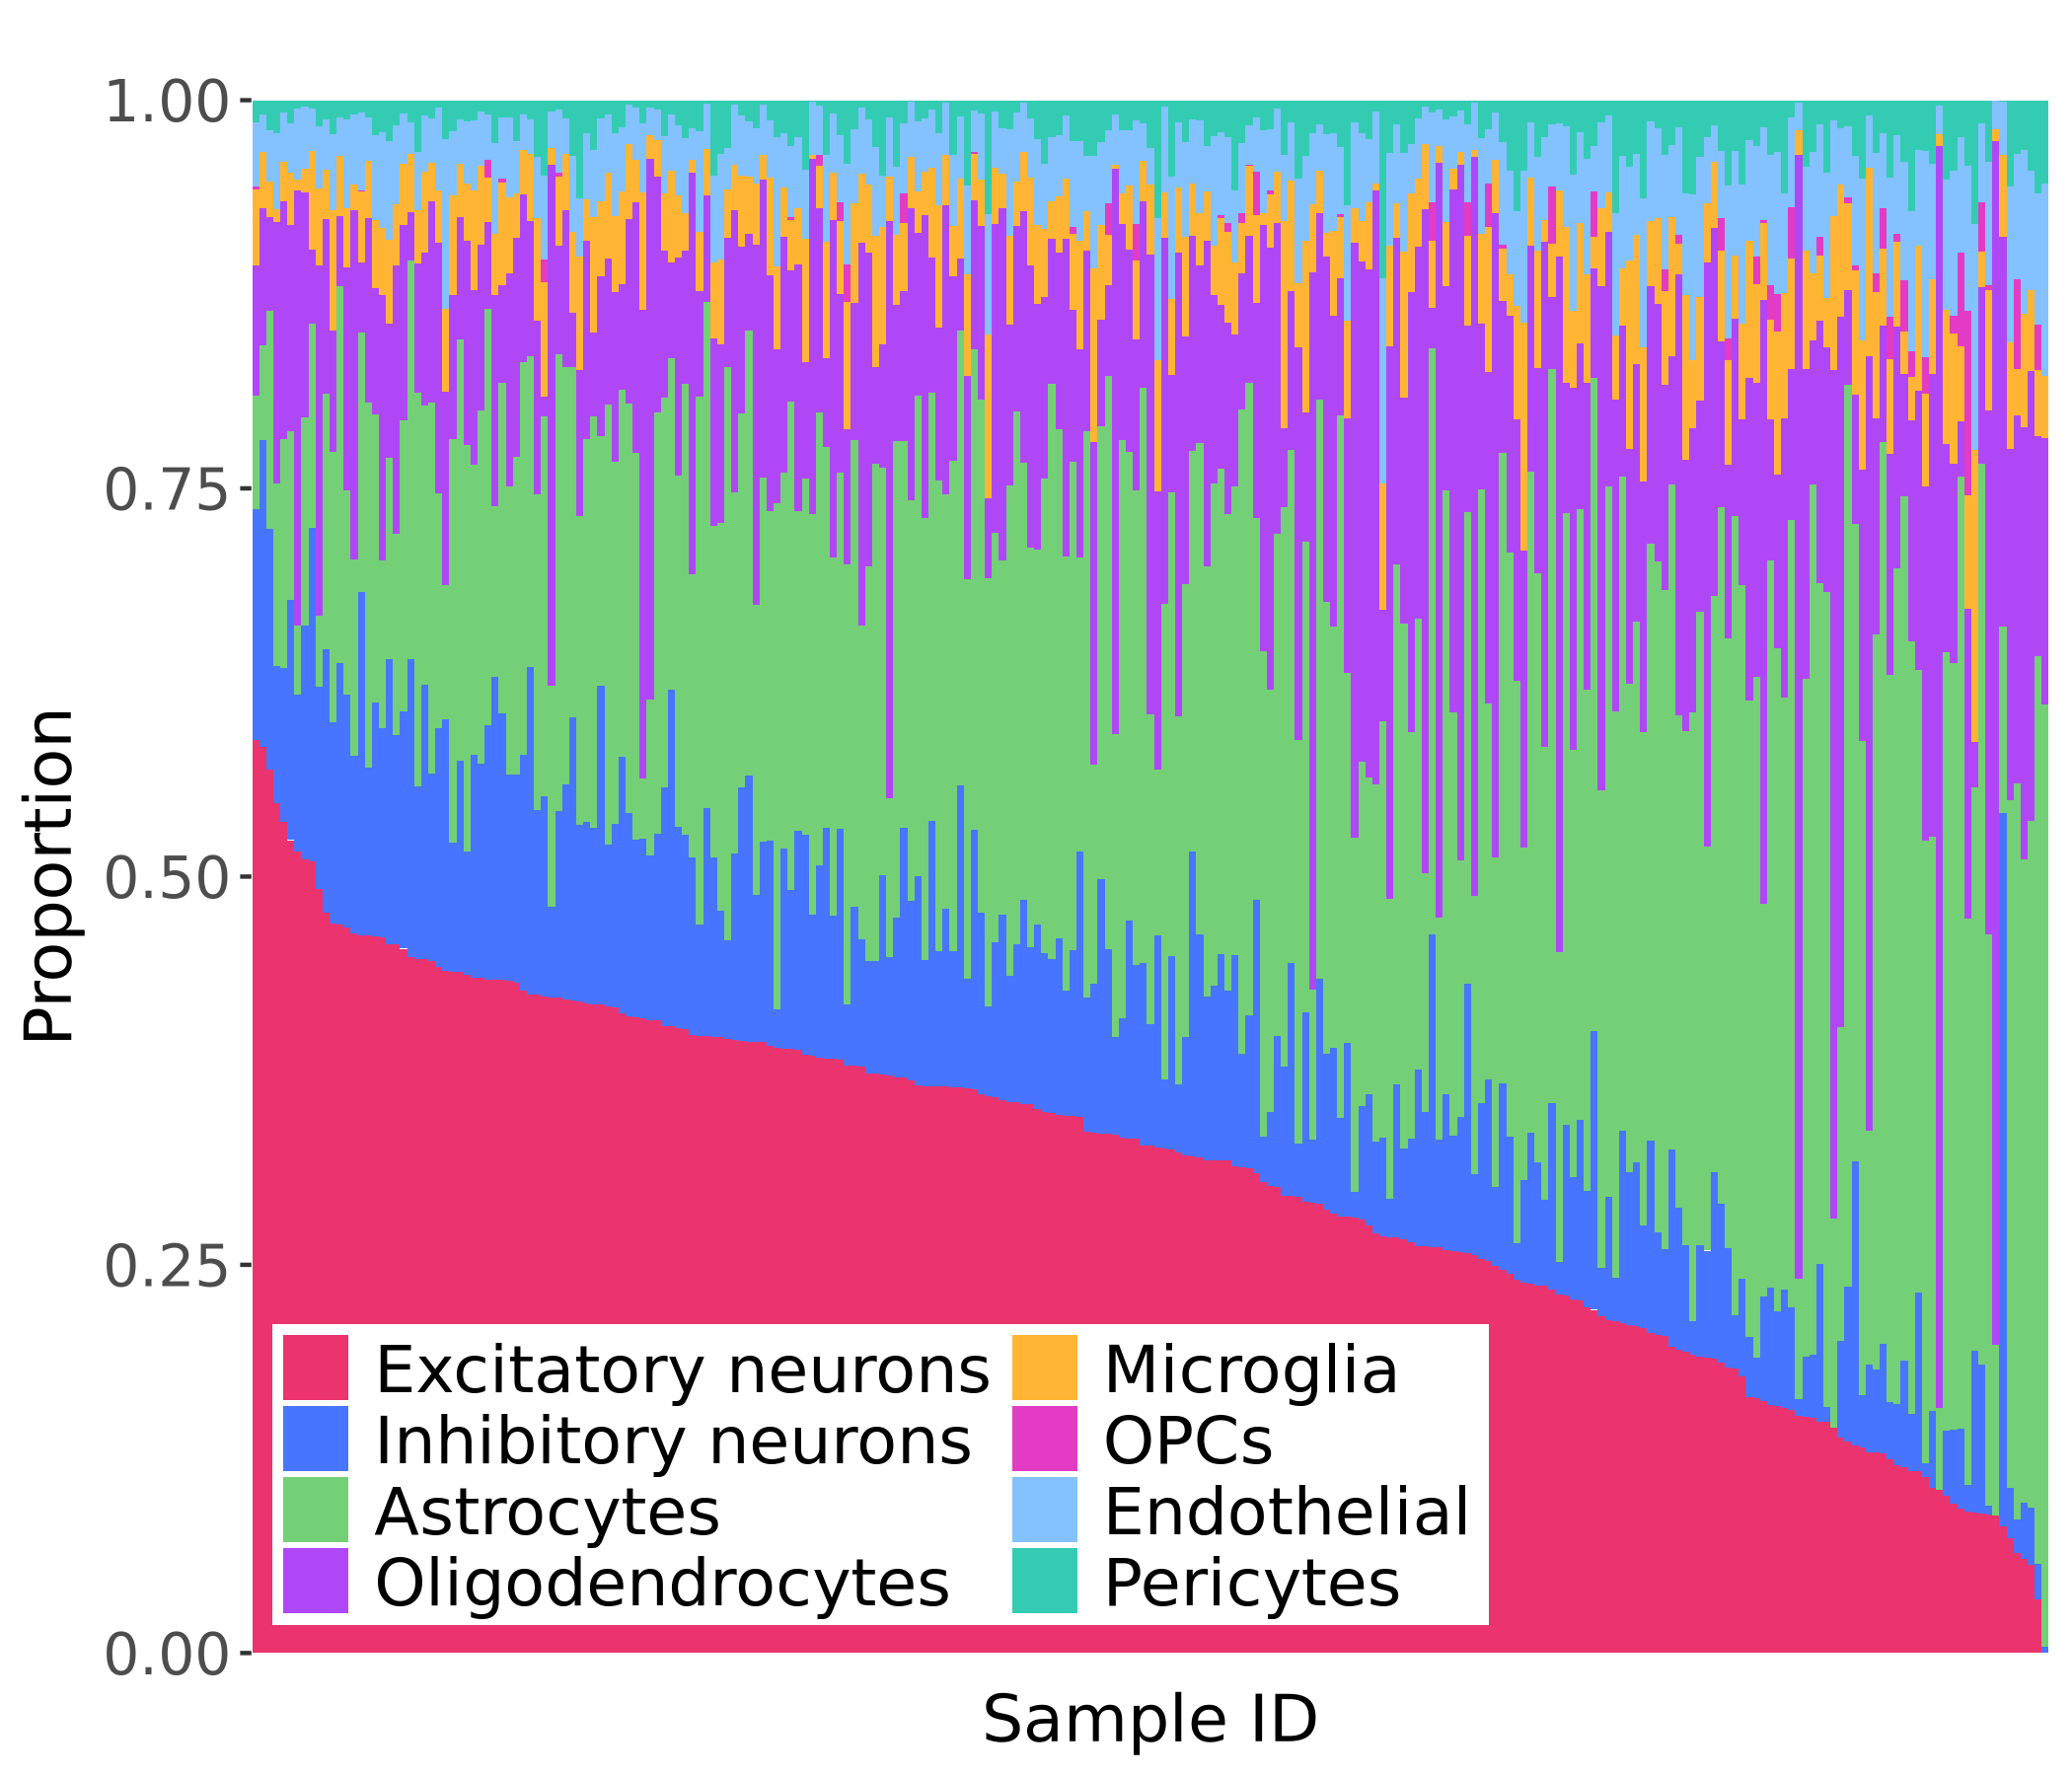

In [68]:
colors <- c("#e60049", "#1a53ff", "#51C455", "#9b19f5", "#ffa300", "#dc0ab4", "#66b2ff", "#00bfa0")
options(repr.plot.width=7, repr.plot.height=6, repr.plot.res=300)
bar = ggplot(long2, aes(fill=factor(Cell, levels=rev(levels)), y=Prop, x=factor(Sample, levels=wide2$Sample))) +
  geom_bar(position="fill", stat="identity", width=1, alpha=0.8) +
  theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.text.y=element_text(size=14),
        axis.title.x=element_text(size=16, margin = margin(t = -12, r = 0, b = 0, l = 0)),
        axis.title.y=element_text(size=16, margin = margin(t = 0, r = 5, b = 0, l = 0)),
        legend.text=element_text(size=16),
        legend.margin=margin(2,6,2,2),
        # legend.box.margin=margin(2,2,2,2),
        legend.box.spacing = unit(4, "pt"),
        legend.position = c(.35, .15),
        # legend.spacing.x = unit(2.0, 'cm'),
        panel.background = element_blank()) +
  guides(fill = guide_legend(nrow = 4)) +
  scale_fill_manual(values=colors, breaks=levels, name=NULL) +
  labs(x='Sample ID', y='Proportion') + ylim(c(0,1))
bar

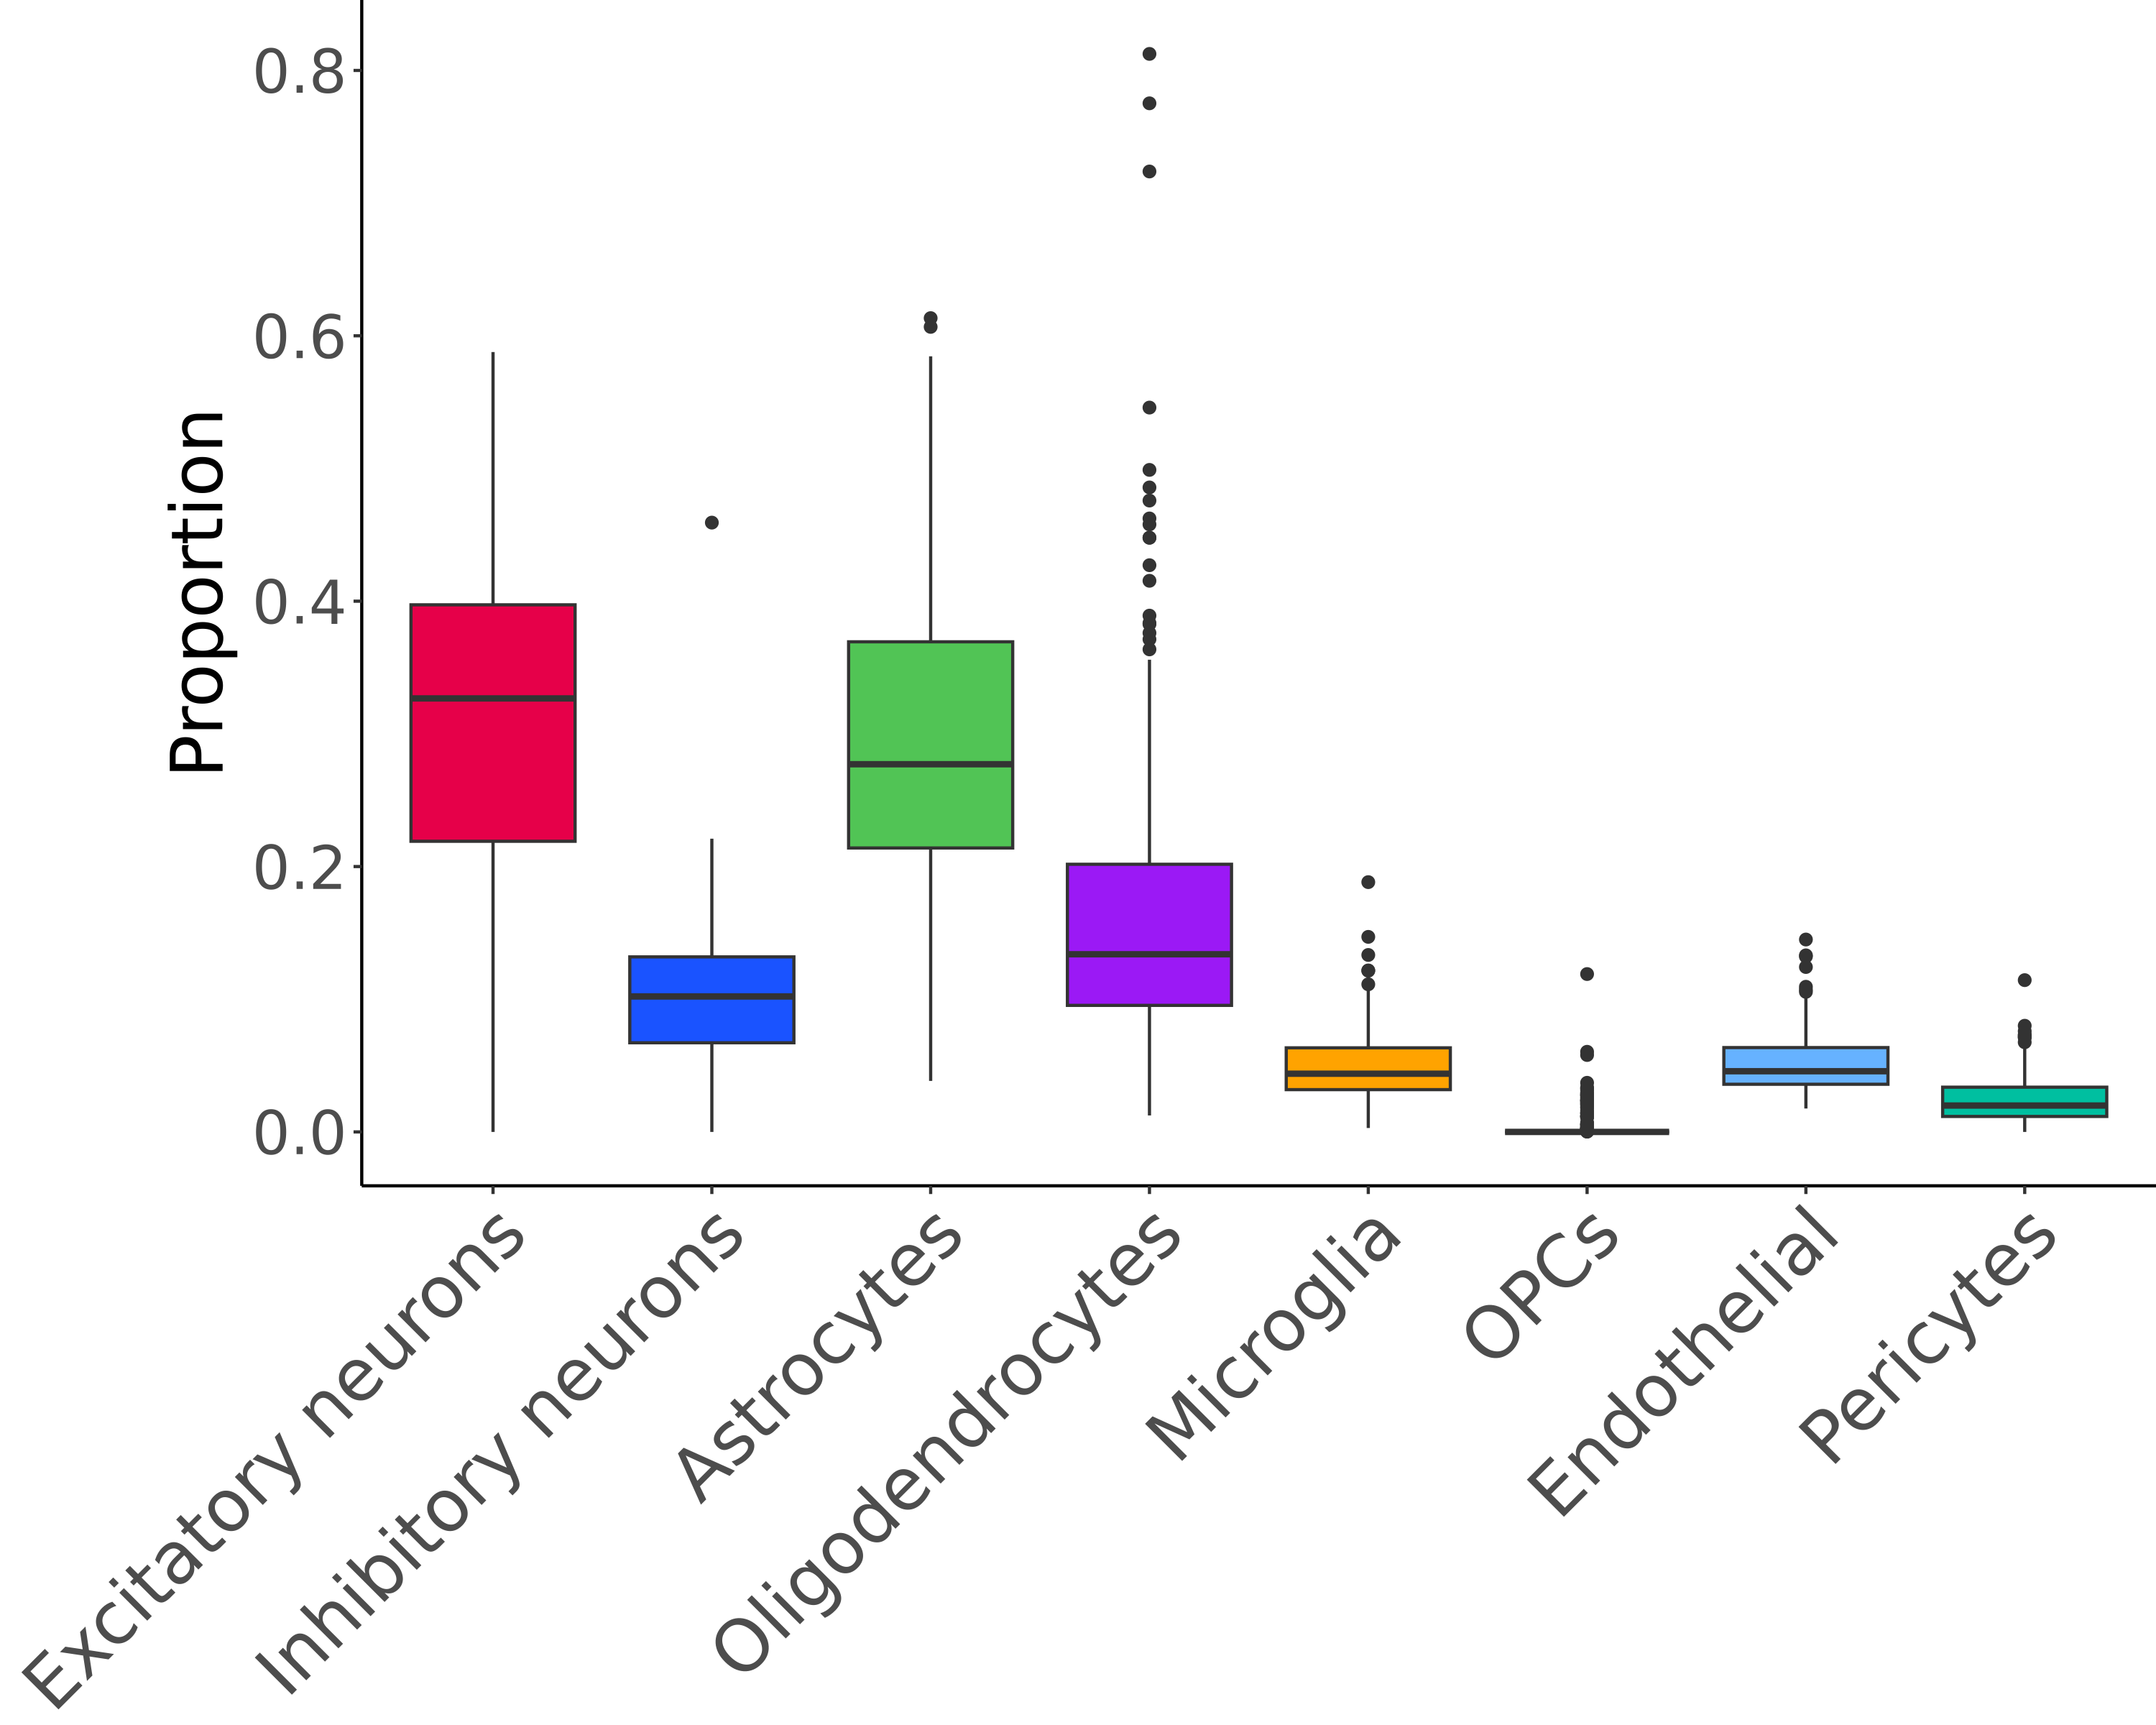

In [124]:
## boxplot
options(repr.plot.width=10, repr.plot.height=8, repr.plot.res=300)
label_font = 24
axis_font = 20
long <- wide %>% pivot_longer(cols=!Sample, names_to='Cell', values_to='Prop')
box = ggplot(long, aes(x=factor(Cell, levels=levels), y=Prop, fill=factor(Cell, levels=levels))) + 
  geom_boxplot() + 
  ylab('Proportion') + theme_classic() +
  theme(axis.text.y=element_text(size=axis_font),
        axis.title.x=element_blank(),
        axis.title.y=element_text(size=label_font, margin = margin(t = 0, r = 5, b = 0, l = 0)),
        axis.text.x = element_text(size=label_font, angle = 45, hjust = 1),
        legend.position = "none",
        panel.background = element_blank(),
        plot.margin = unit(c(0, 0, 0, 2), "cm")) +
  scale_fill_manual(values=colors, breaks=levels, name=NULL)
box